<a href="https://colab.research.google.com/github/zurriyatafatni/LungScanCovidClassification_RandomForest/blob/main/LungScanCovid_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import library
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import feature 
from PIL import Image
from pathlib import Path
import cv2
import os
import re


In [ ]:
#mount dataset from drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
base_dir = '/content/drive/My Drive/lungscan'
#print directory
print(os.listdir(base_dir))

['CT_NonCOVID', 'CT_COVID', 'preprocess']


In [ ]:
#menghitung jumlah data masing-masing class
dir = ['CT_NonCOVID','CT_COVID']
print('Jumlah data masing-masing class')
for i in dir:
  print( i , ':' ,len(os.listdir(base_dir+'/'+ i)))

Jumlah data masing-masing class
CT_NonCOVID : 397
CT_COVID : 349


In [ ]:
# Function to rename multiple files 
def main(): 
  for x in dir:
    for count, filename in enumerate(os.listdir(base_dir+'/'+x+'/')): 
      if (x=='CT_COVID'):
        dst ="covid" + str(count)+".jpg"
        src =base_dir+'/'+x+'/'+ filename 
        dst =base_dir+'/'+x+'/'+ dst
        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 
      else:
        dst ="noncovid" + str(count)+".jpg"
        src =base_dir+'/'+x+'/'+ filename 
        dst =base_dir+'/'+x+'/'+ dst
          
        # rename() function will 
        # rename all the files 
        os.rename(src, dst)
    
# Driver Code 
if __name__ == '__main__': 
      
    # Calling main() function 
    main() 

Dataset


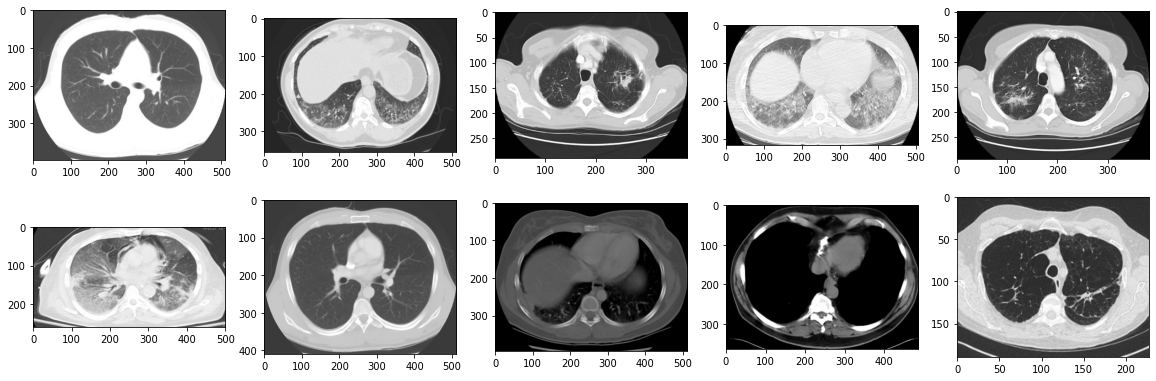

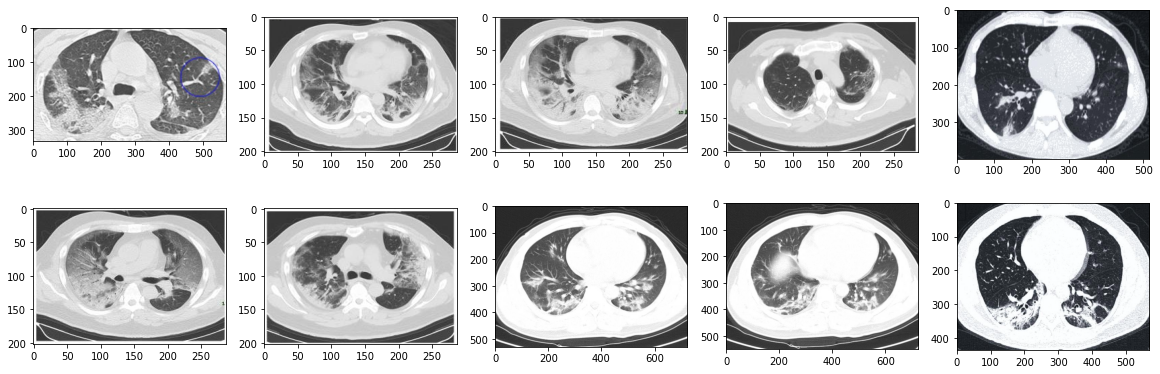

TypeError: ignored

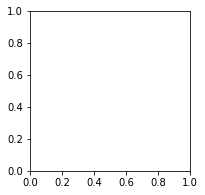

In [ ]:
#visualize dataset
print('Dataset')
for folder in os.listdir(base_dir):
  files = os.listdir(os.path.join(base_dir, folder))

  plt.figure(figsize=(20,10))
 

  i = 0
  for batch in files:
      
    img = cv2.imread(os.path.join(base_dir, folder, batch))

    # imgs.append(img)
    # labels.append(filename[0])
    # descs.append(folder)

    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(img)

    if i == 9:
        break
    i += 1

  plt.show()

## **Fitur Extraction** 
Fitur Exctraction using 2 algorithm with rules as follows:


1.   Fitur Extraction using LBP (*Local Binary Pattern*) -> the matrix result (matrix output LBP) used to input GLCM
2.   Fitur Exctraction using GLCM (*Gray Level Co-occurence Matrix*)


---








1. **Local Binary Pattern (LBP)**

In [ ]:
# Local Binary Pattern
def get_pixel(img, center, x, y): 
      
    new_value = 0
      
    try: 
        # If local neighbourhood pixel  
        # value is greater than or equal 
        # to center pixel values then  
        # set it to 1 
        if img[x][y] >= center: 
            new_value = 1
              
    except: 
        # Exception is required when  
        # neighbourhood value of a center 
        # pixel value is null i.e. values 
        # present at boundaries. 
        pass
      
    return new_value 
   
# Function for calculating LBP 
def lbp_calculated_pixel(img, x, y): 
   
    center = img[x][y] 
   
    val_ar = [] 
      
    # top_left 
    val_ar.append(get_pixel(img, center, x-1, y-1)) 
      
    # top 
    val_ar.append(get_pixel(img, center, x-1, y)) 
      
    # top_right 
    val_ar.append(get_pixel(img, center, x-1, y + 1)) 
      
    # right 
    val_ar.append(get_pixel(img, center, x, y + 1)) 
      
    # bottom_right 
    val_ar.append(get_pixel(img, center, x + 1, y + 1)) 
      
    # bottom 
    val_ar.append(get_pixel(img, center, x + 1, y)) 
      
    # bottom_left 
    val_ar.append(get_pixel(img, center, x + 1, y-1)) 
      
    # left 
    val_ar.append(get_pixel(img, center, x, y-1)) 
       
    # Now, we need to convert binary 
    # values to decimal 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128] 
   
    val = 0
      
    for i in range(len(val_ar)): 
        val += val_ar[i] * power_val[i] 
          
    return val

In [ ]:
# determine extension of images
## covid positive images
path = base_dir+'/CT_COVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'positive image extensions: {ext_set}')

## covid negative images
path = base_dir+'/CT_NonCOVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'negative image extensions: {ext_set}')

positive image extensions: {'.jpg'}
negative image extensions: {'.jpg'}


In [ ]:
## postive
path = base_dir+'/CT_COVID'
pos_li = list(Path(path).glob('*.jpg'))

## negative
path = base_dir+'/CT_NonCOVID'
neg_li = list(Path(path).glob('*.png'))
neg_li.extend(list(Path(path).glob('*.jpg')))

# display number of images
print(f'Postive images: {len(pos_li)}\nNegative images: {len(neg_li)}')

Postive images: 349
Negative images: 397


In [ ]:
#print resolusi citra
imaa = cv2.imread(str(pos_li[0]))
# gray = cv2.cvtColor(imaa,cv2.COLOR_BGR2RGB)
# cv2.imshow("Sda",imaa)
# cv2.waitKey(0) # waits until a key is pressed
# cv2.destroyAllWindows() # destroys the window showing image
# print(gray)
imaa.shape

(332, 566, 3)

In [ ]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 128
pos_data = np.empty((len(pos_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
neg_data = np.empty((len(neg_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ float data type must be used to save precise pixel values

In [ ]:
# convert images to numpy arrays
## positive
for i, img_path in enumerate(sorted(pos_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    pos_data[i] = img
    
## negative
for i, img_path in enumerate(sorted(neg_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    neg_data[i] = img

In [ ]:
# scale image arrays
pos_data /= 255
neg_data /= 255

In [ ]:
#make directory for LBP image
lbp = ['LBP_COVID', 'LBP_NonCOVID']
try:
    os.mkdir(base_dir+'/preprocess/')
    os.mkdir(base_dir+'/preprocess/LBP/')
    for x in lbp:
      os.mkdir(base_dir+'/preprocess/LBP/'+x)
except OSError:
    pass


In [ ]:
# LBP Positif
for i, img_path in enumerate(sorted(pos_li)):
    height, width, _ = pos_data[i].shape
    # Create a numpy array as  
    # the same height and width  
    # of RGB image 
    img_lbp = np.zeros((height, width), 
                       np.uint8)
    
    for j in range(0, height): 
        for k in range(0, width): 
            img_lbp[j, k] = lbp_calculated_pixel(pos_data[i], j, k)
    
    newPath = str(pos_li[i]).split('/')
    fileLoc = base_dir+ "/preprocess/LBP/LBP_COVID/"+newPath[6]
    cv2.imwrite(fileLoc, img_lbp)

In [ ]:
# LBP Negatif
for i, img_path in enumerate(sorted(neg_li)):
    height, width, _ = neg_data[i].shape
    # Create a numpy array as  
    # the same height and width  
    # of RGB image 
    img_lbp = np.zeros((height, width), 
                       np.uint8)
    
    for j in range(0, height): 
        for k in range(0, width): 
            img_lbp[j, k] = lbp_calculated_pixel(neg_data[i], j, k)
    
    newPath = str(neg_li[i]).split('/')
    fileLoc = base_dir+ "/preprocess/LBP/LBP_NonCOVID/"+newPath[6]
    cv2.imwrite(fileLoc, img_lbp)

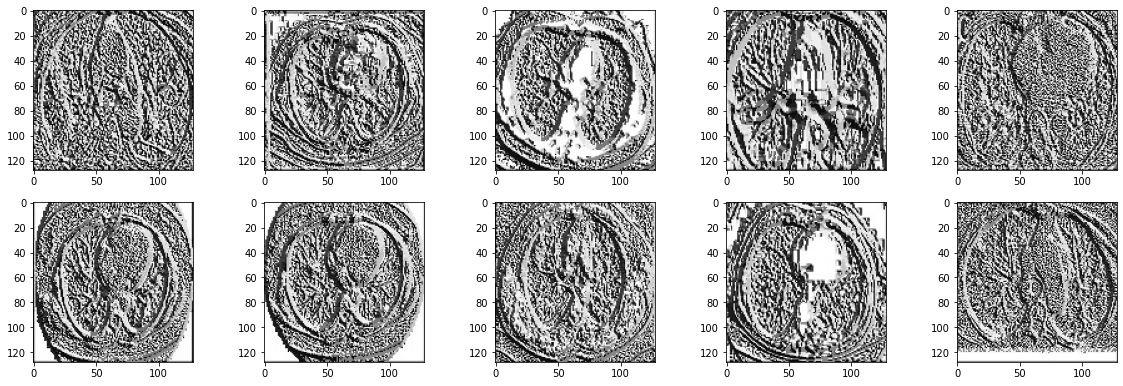

In [ ]:
#visualize LBP image
files = os.listdir(os.path.join(base_dir+'/preprocess/LBP/LBP_COVID/'))

plt.figure(figsize=(20,10))

i = 0
for batch in files:
    
  img = cv2.imread(os.path.join(base_dir+'/preprocess/LBP/LBP_COVID/'+ batch))

  # imgs.append(img)
  # labels.append(filename[0])
  # descs.append(folder)

  plt.subplot(3, 5, i+1)
  plt.grid(False)
  plt.imshow(img)

  if i == 9:
      break
  i += 1

plt.show()

**2. Gray Level Co-occurence Matrix (GLCM)**

In [ ]:
#Gray Level Co-occurence Matrix
# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")
      
def label_nama(nama_label):
    if nama_label == 'LBP_COVID':
        return 1
    else:
        return 0

# -------------------- Load Dataset ------------------------
 
dataset_dir = base_dir+"/preprocess/" 

imgs = [] #list image matrix 
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # h, w = gray.shape
            # ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
            # crop = gray[ymin:ymax, xmin:xmax]
            
            # resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
            
            imgs.append(gray)
#             labels.append(normalize_label(os.path.splitext(filename)[0]))
            nama_label = os.path.splitext(sub_folder)[0]
            labels.append(label_nama(nama_label))
            descs.append(normalize_desc(folder, sub_folder))
            
            print_progress(i, len_sub_folder, folder, sub_folder, filename)


[##########] folder : LBP/LBP_COVID/ ----> file : covid348.jpg


In [ ]:
print(len(labels))

746


In [ ]:
from skimage.feature import greycomatrix, greycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

In [ ]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

#save to csv
glcm_df.to_csv("glcm_COVID_dataset.csv")

glcm_df.reset_index(drop=True)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,105.518166,105.322255,101.557927,104.667014,-0.000985,0.000981,0.043222,0.008053,0.024365,0.023825,0.027797,0.025012,17046.289507,17042.917729,16361.126651,16930.151535,0.000143,0.000143,0.000142,0.000142,0.011975,0.011975,0.011897,0.011936,1
1,98.002541,98.980294,96.087271,101.540843,0.057595,0.051017,0.076188,0.012528,0.034549,0.028015,0.036936,0.028761,15393.085747,15568.795200,15182.800305,16201.747789,0.000133,0.000124,0.000142,0.000125,0.011534,0.011124,0.011922,0.011187,1
2,94.374174,92.207856,89.537602,94.079800,0.113334,0.140193,0.163071,0.107054,0.067049,0.065294,0.078771,0.064444,15141.677020,14644.732960,14279.585620,15216.271527,0.001177,0.001070,0.001536,0.001139,0.034307,0.032706,0.039194,0.033745,1
3,100.520960,94.946215,86.745681,101.049688,0.016276,0.088517,0.173297,-0.004160,0.034753,0.039035,0.053651,0.032877,15935.745427,14781.724831,13405.821519,16290.970994,0.000148,0.000151,0.000183,0.000146,0.012186,0.012289,0.013509,0.012090,1
4,103.551385,103.677810,102.108041,103.798452,0.005256,0.005541,0.021609,0.004078,0.027084,0.025955,0.026596,0.026327,16459.442264,16493.291753,16237.501334,16517.683728,0.000160,0.000157,0.000158,0.000159,0.012645,0.012530,0.012577,0.012601,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,101.934515,99.872984,98.086700,103.339685,0.026952,0.050295,0.068136,0.000387,0.029316,0.029602,0.033885,0.029576,16249.372142,15864.051574,15591.292619,16700.074337,0.000138,0.000144,0.000142,0.000145,0.011740,0.012005,0.011909,0.012033,0
742,103.029853,102.197646,101.572282,104.916038,0.011218,0.027468,0.032285,-0.010698,0.028679,0.027279,0.028154,0.025892,16645.265498,16385.044290,16312.353659,17030.794550,0.000151,0.000146,0.000150,0.000150,0.012294,0.012097,0.012243,0.012242,0
743,98.534680,96.376626,97.557038,100.680801,0.063205,0.087755,0.067928,0.025379,0.039729,0.038737,0.037031,0.035484,15554.229294,15105.872334,15483.236916,16137.770421,0.000197,0.000160,0.000164,0.000155,0.014042,0.012664,0.012825,0.012446,0
744,99.033346,98.950052,94.553735,99.777055,0.059994,0.064619,0.117278,0.050408,0.048630,0.042459,0.056973,0.043051,15874.309515,15788.363033,14983.309578,16027.888007,0.000444,0.000373,0.000683,0.000389,0.021060,0.019318,0.026125,0.019725,0


In [ ]:
fitur = pd.read_csv('glcm_COVID_dataset.csv')
fitur = pd.DataFrame(fitur)
fitur = fitur.drop(fitur.columns[0], axis='columns')
# fitur.reset_index(drop=True)
fitur.head()

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,105.518166,105.322255,101.557927,104.667014,-0.000985,0.000981,0.043222,0.008053,0.024365,0.023825,0.027797,0.025012,17046.289507,17042.917729,16361.126651,16930.151535,0.000143,0.000143,0.000142,0.000142,0.011975,0.011975,0.011897,0.011936,1
1,98.002541,98.980294,96.087271,101.540843,0.057595,0.051017,0.076188,0.012528,0.034549,0.028015,0.036936,0.028761,15393.085747,15568.795200,15182.800305,16201.747789,0.000133,0.000124,0.000142,0.000125,0.011534,0.011124,0.011922,0.011187,1
2,94.374174,92.207856,89.537602,94.079800,0.113334,0.140193,0.163071,0.107054,0.067049,0.065294,0.078771,0.064444,15141.677020,14644.732960,14279.585620,15216.271527,0.001177,0.001070,0.001536,0.001139,0.034307,0.032706,0.039194,0.033745,1
3,100.520960,94.946215,86.745681,101.049688,0.016276,0.088517,0.173297,-0.004160,0.034753,0.039035,0.053651,0.032877,15935.745427,14781.724831,13405.821519,16290.970994,0.000148,0.000151,0.000183,0.000146,0.012186,0.012289,0.013509,0.012090,1
4,103.551385,103.677810,102.108041,103.798452,0.005256,0.005541,0.021609,0.004078,0.027084,0.025955,0.026596,0.026327,16459.442264,16493.291753,16237.501334,16517.683728,0.000160,0.000157,0.000158,0.000159,0.012645,0.012530,0.012577,0.012601,1


In [ ]:
# labelss= np.array(fitur['label'])
X = fitur.drop('label', axis=1)
y = fitur[['label']]


# xx = np.array(X)
# yy = np.array(y)
# fitur = np.array(fitur)

In [ ]:
# X = np.array(fitur['label'])
# y = np.array(X)

In [ ]:
from sklearn.model_selection import train_test_split
#split data to data train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_test.values.ravel()

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
# from jcopml.plot import plot_confusion_matrix

In [ ]:
from sklearn import metrics


# print ("Precision:",precision,"Recall:", recall)
# print( "reported: ", sum(pred_test), ' and total:', len(pred_test))

for i in range(1,101):
    model_rf = RandomForestClassifier(n_estimators=i, criterion='entropy')
    model_rf = model_rf.fit(X_train, y_train.values.ravel())
    hasil_prediksi_rf = model_rf.predict(X_test)
    # errors = abs(hasil_prediksi_rf - y_test)
    # mape = np.mean(100*(errors/y_test.values.ravel()))
    precision = metrics.precision_score(y_test,hasil_prediksi_rf)
    recall = metrics.recall_score(y_test,hasil_prediksi_rf)
    akurasi_rf = accuracy_score(y_test.values.ravel(), hasil_prediksi_rf)*100
#     print(akurasi_rf)
    print('n_estimator = {} Akurasi = {} Precision = {} Recall = {}' . format(i, akurasi_rf, precision*100, recall*100))

n_estimator = 1 Akurasi = 64.73214285714286 Precision = 66.66666666666666 Recall = 57.65765765765766
n_estimator = 2 Akurasi = 62.05357142857143 Precision = 75.0 Recall = 35.13513513513514
n_estimator = 3 Akurasi = 62.5 Precision = 64.83516483516483 Recall = 53.153153153153156
n_estimator = 4 Akurasi = 61.16071428571429 Precision = 70.0 Recall = 37.83783783783784
n_estimator = 5 Akurasi = 62.5 Precision = 62.857142857142854 Recall = 59.45945945945946
n_estimator = 6 Akurasi = 63.39285714285714 Precision = 68.35443037974683 Recall = 48.64864864864865
n_estimator = 7 Akurasi = 67.85714285714286 Precision = 69.6969696969697 Recall = 62.16216216216216
n_estimator = 8 Akurasi = 62.5 Precision = 68.0 Recall = 45.94594594594595
n_estimator = 9 Akurasi = 61.60714285714286 Precision = 63.1578947368421 Recall = 54.054054054054056
n_estimator = 10 Akurasi = 64.28571428571429 Precision = 69.1358024691358 Recall = 50.45045045045045
n_estimator = 11 Akurasi = 63.39285714285714 Precision = 65.2631578

In [ ]:
from sklearn import metrics
pred_test = model_rf.predict(X_test)
precision = metrics.precision_score(y_test,pred_test)
recall = metrics.recall_score(y_test,pred_test)
print ("Precision:",precision,"Recall:", recall)
print( "reported: ", sum(pred_test), ' and total:', len(pred_test))

# errors =  abs(pred_test - y_test.values.ravel())
# mape = np.mean(100 * (errors / y_test.values.ravel()))
# accuracy = 100 - mape
# print(accuracy)

Precision: 0.6947368421052632 Recall: 0.5945945945945946
reported:  95  and total: 224
nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


[0.65714286 0.70214286 0.74892857 0.73107143 0.71714286 0.63785714
 0.70879121 0.6981685  0.66886447 0.62205882]


In [ ]:
print("=== Confusion Matrix ===")
cf_matrix = confusion_matrix(y_test, hasil_prediksi_rf, labels=[1,0])
print(cf_matrix)
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, hasil_prediksi_rf))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[65 46]
 [27 86]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       113
           1       0.71      0.59      0.64       111

    accuracy                           0.67       224
   macro avg       0.68      0.67      0.67       224
weighted avg       0.68      0.67      0.67       224



=== All AUC Scores ===
[0.65714286 0.70214286 0.74892857 0.73107143 0.71714286 0.63785714
 0.70879121 0.6981685  0.66886447 0.62205882]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6892168713639302


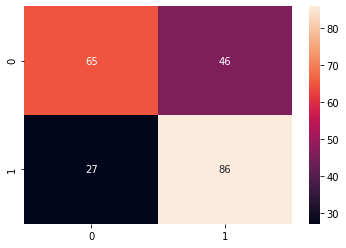

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

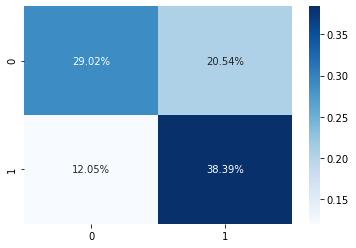

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

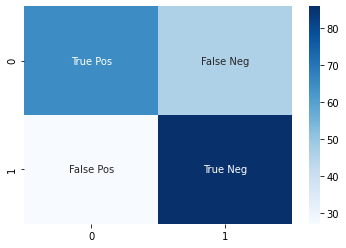

In [ ]:
labels = ['True Pos','False Neg','False Pos','True Neg']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

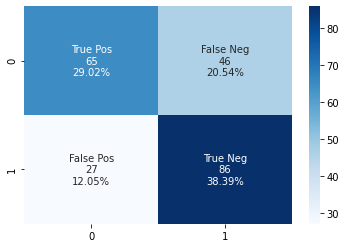

In [ ]:
group_names = ['True Pos','False Neg','False Pos','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
for i in range(1,101):
    model = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='euclidean')
    model.fit(X_train, y_train.values.ravel())
    hasil_prediksi = model.predict(X_test)
    akurasi_knn = accuracy_score(y_test.values.ravel(), hasil_prediksi)*100
#     print(akurasi_knn)
    print('n_neighbor = {} Akurasi = {}'. format(i, akurasi_knn))

n_neighbor = 1 Akurasi = 57.58928571428571
n_neighbor = 2 Akurasi = 57.58928571428571
n_neighbor = 3 Akurasi = 58.48214285714286
n_neighbor = 4 Akurasi = 60.71428571428571
n_neighbor = 5 Akurasi = 58.92857142857143
n_neighbor = 6 Akurasi = 59.375
n_neighbor = 7 Akurasi = 62.05357142857143
n_neighbor = 8 Akurasi = 62.5
n_neighbor = 9 Akurasi = 61.60714285714286
n_neighbor = 10 Akurasi = 62.5
n_neighbor = 11 Akurasi = 62.5
n_neighbor = 12 Akurasi = 63.83928571428571
n_neighbor = 13 Akurasi = 64.73214285714286
n_neighbor = 14 Akurasi = 63.39285714285714
n_neighbor = 15 Akurasi = 63.39285714285714
n_neighbor = 16 Akurasi = 63.39285714285714
n_neighbor = 17 Akurasi = 63.83928571428571
n_neighbor = 18 Akurasi = 61.16071428571429
n_neighbor = 19 Akurasi = 63.83928571428571
n_neighbor = 20 Akurasi = 62.94642857142857
n_neighbor = 21 Akurasi = 64.28571428571429
n_neighbor = 22 Akurasi = 63.39285714285714
n_neighbor = 23 Akurasi = 63.83928571428571
n_neighbor = 24 Akurasi = 63.39285714285714
n_n